In [2]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
import joblib

In [4]:
from google.colab import files
import io
import pandas as pd

uploaded = files.upload()
filename = list(uploaded.keys())[0]
print("Uploaded:", filename)
df = pd.read_csv(io.BytesIO(uploaded[filename]))

Saving bridge_dataset.csv to bridge_dataset.csv
Uploaded: bridge_dataset.csv


In [5]:
print("Dataset Shape:", df.shape)
print("Columns:", df.columns)

Dataset Shape: (1340, 15)
Columns: Index(['timestamp', 'bridge_id', 'sensor_id', 'acceleration_x',
       'acceleration_y', 'acceleration_z', 'temperature_c', 'humidity_percent',
       'wind_speed_mps', 'fft_peak_freq', 'fft_magnitude', 'degradation_score',
       'structural_condition', 'damage_class', 'forecast_score_next_30d'],
      dtype='object')


In [6]:
#  Map damage_class to project-specific labels

label_mapping = {
    "No Damage": "Normal",
    "Severe": "Abnormal",
    "Minor": "Maybe Abnormal",
    "Moderate": "Maybe Abnormal"}
df["Label"] = df["damage_class"].map(label_mapping)

print("\nLabel Distribution:")
print(df["Label"].value_counts())


Label Distribution:
Label
Maybe Abnormal    879
Normal            366
Abnormal           95
Name: count, dtype: int64


In [7]:
# Feature selection & preprocessing

# ===== LEAKAGE REMOVAL =====
# Drop columns too correlated with label
corrs = df.corr(numeric_only=True)["Label"].sort_values(ascending=False) if "Label" in df.select_dtypes(include=[np.number]).columns else None

# Hard-coded leakage columns from your correlation results
leakage_cols = ["structural_condition", "degradation_score", "forecast_score_next_30d"]

# Final feature set
features = [col for col in df.columns if col not in [
    "timestamp", "bridge_id", "damage_class", "Label", "sensor_id"
] + leakage_cols]
X = df[features].values
y = df["Label"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_test_scaled = scaler.transform(X_test)

In [ ]:
# Split Data: clear vs ambiguous
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

clear_mask = df["Label"].isin(["Normal", "Abnormal"])
ambiguous_mask = df["Label"] == "Maybe Abnormal"

X_clear = X_scaled[clear_mask]
y_clear = y[clear_mask]

X_ambiguous = X_scaled[ambiguous_mask]
y_ambiguous = y[ambiguous_mask]
le = LabelEncoder()
y_clear_enc = le.fit_transform(y_clear)  # Normal=0, Abnormal=1

# ==== Oversample minority class ====
smote = SMOTE(random_state=42)
X_bal, y_bal_enc = smote.fit_resample(X_clear, y_clear_enc)
y_bal = le.inverse_transform(y_bal_enc)

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)


In [9]:
#  Semi-Supervised Learning (Self-training)

base_rf = RandomForestClassifier(n_estimators=100,max_depth=None, random_state=42)
base_rf.fit(X_train, y_train)
self_training_model = SelfTrainingClassifier(base_rf)

# Combine labeled + unlabeled (ambiguous as unlabeled)
X_train_full = np.vstack([X_train, X_ambiguous])
y_train_full = np.concatenate([y_train, np.array([-1] * len(X_ambiguous))])

self_training_model.fit(X_train_full, y_train_full)
print(self_training_model)

SelfTrainingClassifier(estimator=RandomForestClassifier(random_state=42))


In [10]:
#  Fuzzy Classification (Fuzzy C-Means)
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    X_scaled.T, m=2, c=3, error=0.005, maxiter=1000, init=None
)

# u.T gives membership per sample
fuzzy_memberships = pd.DataFrame(u.T, columns=["Fuzzy_Normal", "Fuzzy_Abnormal", "Fuzzy_Ambiguous"])
ambig_labels = np.array(["Maybe Abnormal"] * len(X_ambiguous))
abn_idx = fuzzy_memberships.loc[ambiguous_mask, "Fuzzy_Abnormal"] > 0.6
ambig_labels[abn_idx.values] = "Abnormal"

In [11]:
# Predictions with Threshold Logic
# ===============================
y_proba = self_training_model.predict_proba(X_test)
y_pred_conf = []

confidence_threshold = 0.75  # If max probability < threshold → Maybe Abnormal

for probs in y_proba:
    max_prob = np.max(probs)
    pred_label = self_training_model.classes_[np.argmax(probs)]
    if max_prob < confidence_threshold:
        y_pred_conf.append("Maybe Abnormal")
    else:
        y_pred_conf.append(pred_label)



=== Classification Report (Clear Labels) ===
              precision    recall  f1-score   support

    Abnormal       0.79      0.62      0.70        74
      Normal       0.69      0.84      0.75        73

    accuracy                           0.73       147
   macro avg       0.74      0.73      0.73       147
weighted avg       0.74      0.73      0.72       147



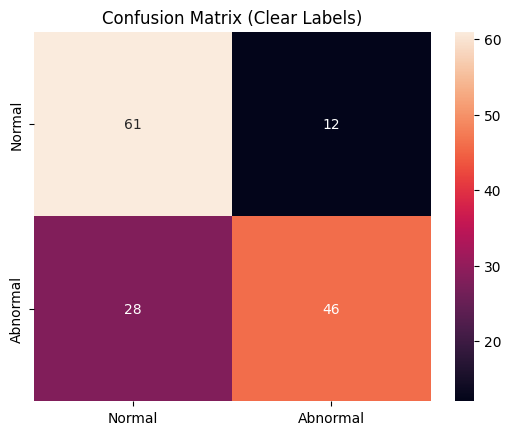

Ambiguous Catch Percentage: 23.55%

=== Fuzzy vs Hard Class Confusion ===
Label            Abnormal  Maybe Abnormal  Normal
row_0                                            
Fuzzy_Abnormal         49             406     154
Fuzzy_Ambiguous        35             294     138
Fuzzy_Normal           11             179      74


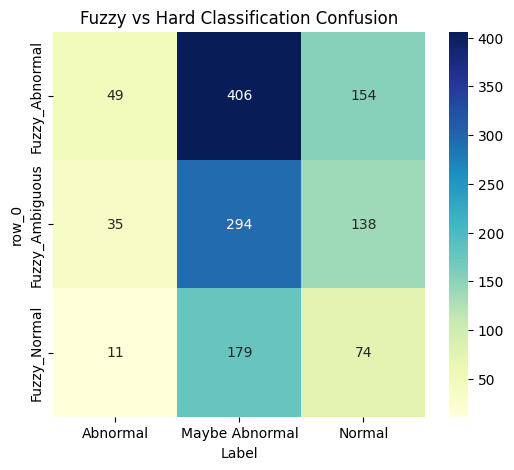

In [13]:
y_pred = self_training_model.predict(X_test)

print("\n=== Classification Report (Clear Labels) ===")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=["Normal", "Abnormal"])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.title("Confusion Matrix (Clear Labels)")
plt.show()

# Ambiguous catch percentage

ambig_preds = []
ambig_proba = self_training_model.predict_proba(X_ambiguous)
for probs in ambig_proba:
    if np.max(probs) < confidence_threshold:
        ambig_preds.append("Maybe Abnormal")
    else:
        ambig_preds.append(self_training_model.classes_[np.argmax(probs)])

ambig_caught = np.sum(np.array(ambig_preds) == "Maybe Abnormal") / len(ambig_preds) * 100
print(f"Ambiguous Catch Percentage: {ambig_caught:.2f}%")
# ===== Fuzzy vs Hard Class Confusion =====
fuzzy_max_class = fuzzy_memberships.idxmax(axis=1)
fuzzy_vs_hard = pd.crosstab(fuzzy_max_class, df["Label"])
print("\n=== Fuzzy vs Hard Class Confusion ===")
print(fuzzy_vs_hard)
plt.figure(figsize=(6,5))
sns.heatmap(fuzzy_vs_hard, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Fuzzy vs Hard Classification Confusion")
plt.show()

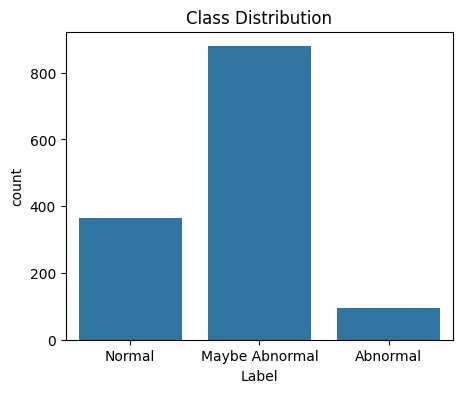

In [14]:
#  Visualizations


# Class Distribution
plt.figure(figsize=(5,4))
sns.countplot(data=df, x="Label", order=["Normal","Maybe Abnormal","Abnormal"])
plt.title("Class Distribution")
plt.show()

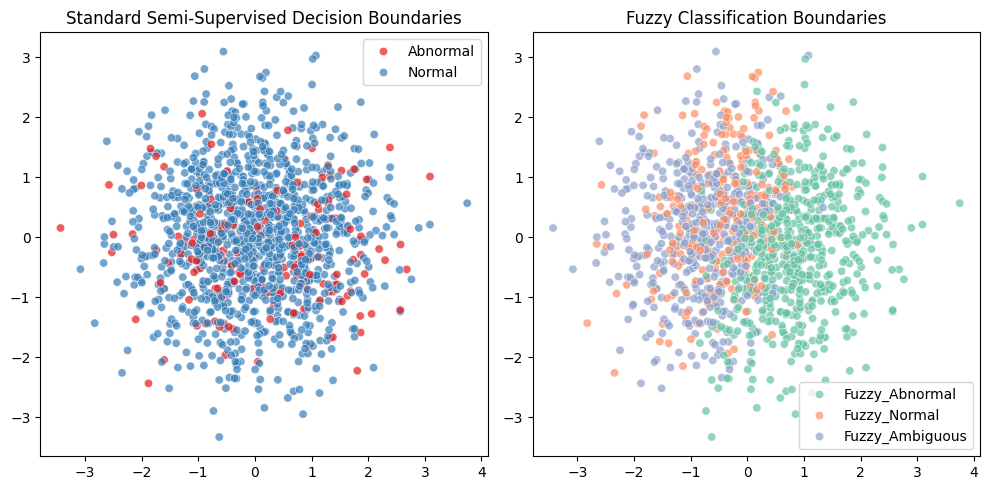

In [15]:
# Compare standard vs fuzzy/semi-supervised model boundaries
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,5))

# Standard (Semi-supervised) plot
plt.subplot(1,2,1)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=self_training_model.predict(X_scaled), palette="Set1", alpha=0.7)
plt.title("Standard Semi-Supervised Decision Boundaries")
plt.legend(loc="best")

# Fuzzy plot
plt.subplot(1,2,2)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=fuzzy_max_class, palette="Set2", alpha=0.7)
plt.title("Fuzzy Classification Boundaries")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [16]:
#  Save Model & Preprocessing for Streamlit
# Save semi-supervised model
joblib.dump(self_training_model, "semi_supervised_model.pkl")

# Save scaler
joblib.dump(scaler, "scaler.pkl")

# Save fuzzy model parameters
fuzzy_data = {
    "centers": cntr,
    "m": 2.0
}
joblib.dump(fuzzy_data, "fuzzy_model.pkl")

print("✅ Model, Scaler, and Fuzzy Data saved successfully!")

✅ Model, Scaler, and Fuzzy Data saved successfully!
